# Water detection with several sensors
Let's use EOReader for water detection, using several sensors over the same area

## Imports

In [1]:
# Imports
import os
import numpy as np
import xarray as xr

## Core functions
- A function loading the Normalized Water Index (`NDWI`)
- A function extracting water through a threshold

In [2]:
def load_ndwi(prod, res):
    """
    Load NDWI index (and rename the array)
    """
    # Read NDWI index
    ndwi = prod.load(NDWI)[NDWI]
    ndwi_name = f"{ndwi.attrs['sensor']} NDWI"
    return ndwi.rename(ndwi_name)

def extract_water(ndwi):
    """
    Extract water from NDWI index (and rename the array)
    """
    # Assert water bodies when NDWI index > 0.2
    water = xr.where(ndwi > 0.2, 1, 0)

    # Set nodata where ndwi is nan.
    # WARNING: the function xr.DataArray.where sets by default np.nan where the condition is false !
    # See here: http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html
    water = water.where(~np.isnan(ndwi))

    # Plot a subsampled version
    water_name = f"{ndwi.attrs['sensor']} WATER"
    water = water.rename(water_name)
    water.attrs["long_name"] = "Water detection"
    return water.rename(water_name)

## Create logger

In [3]:
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

## Linking some data 

First of all, we need some satellite data.  
Let's take 3 products covering approximately the same area (over DAX in France):
- One Landsat-8 OLCI collection 2
- One Landsat-5 TM collection 2
- One Sentinel-2 L2A

In [4]:
prod_folder = os.path.join("/home", "data", "DS3", "CI", "extracteo", "water")
paths = [  
    # Landsat-8 OLCI collection 2    
    os.path.join(prod_folder, "LC08_L1TP_200030_20201220_20210310_02_T1.tar"),
    # Landsat-5 TM collection 2    
    os.path.join(prod_folder, "LT05_L1TP_200030_20111110_20200820_02_T1.tar"),
    # Sentinel-2 L2A
    os.path.join(prod_folder, "S2A_MSIL2A_20191215T110441_N0213_R094_T30TXP_20191215T122756.zip"),
]

## Process these products

In [5]:
from eoreader.reader import Reader
from eoreader.bands import *

# Create the reader
eoreader = Reader()

# Loop on all the products
water_arrays = []
ndwi_arrays = []
extents = []
for path in paths:
    logger.info(f"*** {os.path.basename(path)} ***")
    
    # Open the product
    prod = eoreader.open(path, remove_tmp=True)
    
    # Get extents
    extents.append(prod.extent)
    
    # Read NDWI index
    # 6Let's say we want a 60. meters resolution
    ndwi = load_ndwi(prod, res=60.)
    ndwi_arrays.append(ndwi)
    
    # Extract water
    water_arrays.append(extract_water(ndwi))
    logger.info("\n")

*** LC08_L1TP_200030_20201220_20210310_02_T1.tar ***
Loading bands ['GREEN', 'NIR']
Read GREEN
Manage invalid pixels for band GREEN
Read NIR
Manage invalid pixels for band NIR
Loading index ['NDWI']


*** LT05_L1TP_200030_20111110_20200820_02_T1.tar ***
Loading bands ['GREEN', 'NIR']
Read GREEN
Manage invalid pixels for band GREEN
Read NIR
Manage invalid pixels for band NIR
Loading index ['NDWI']


*** S2A_MSIL2A_20191215T110441_N0213_R094_T30TXP_20191215T122756.zip ***
Loading bands ['GREEN', 'NIR']
Read GREEN
Manage invalid pixels for band GREEN
Read NIR
Manage invalid pixels for band NIR
Loading index ['NDWI']




## Plot the result

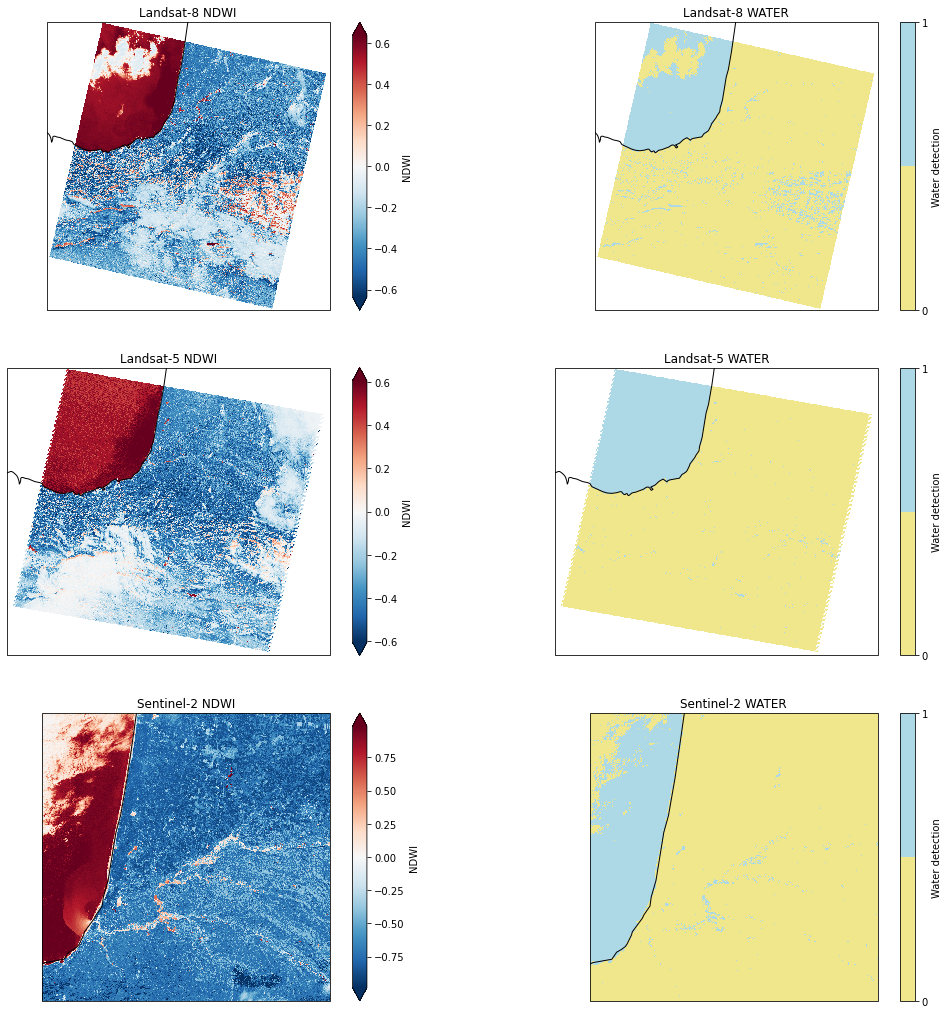

In [6]:
# Plot the tiles
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
from shapely.errors import ShapelyDeprecationWarning
import warnings

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

nrows = len(paths)
plt.figure(figsize=(6 * nrows, 6 * nrows))
cmap = ListedColormap(['khaki', 'lightblue'])
for i in range(nrows):
    # Compute cartopy projection (EOReader always is in UTM)
    extent = extents[i]
    str_epsg = str(extent.crs.to_epsg())
    zone = str_epsg[-2:]
    is_south = str_epsg[2] == 7
    proj = ccrs.UTM(zone, is_south)

    # Get extent values
    # The extents must be defined in the form (min_x, max_x, min_y, max_y)
    bounds = extent.bounds
    extent_val = [bounds.minx[0], bounds.maxx[0], bounds.miny[0], bounds.maxy[0]]

    # Plot NDWI
    axes = plt.subplot(nrows, 2, 2*i+1, projection=proj)
    axes.set_extent(extent_val, proj)
    ndwi_arrays[i][0, ::10, ::10].plot.imshow(origin='upper', extent=extent_val, transform=proj, robust=True)
    axes.coastlines(linewidth=1)
    axes.set_title(ndwi_arrays[i].name)
    
    # Plot water
    axes = plt.subplot(nrows, 2, 2*i+2, projection=proj)
    axes.set_extent(extent_val, proj)
    water_arrays[i][0, ::10, ::10].plot.imshow(origin='upper', extent=extent_val, transform=proj, cmap=cmap, cbar_kwargs={'ticks': [0, 1]})
    axes.coastlines(linewidth=1)
    axes.set_title(water_arrays[i].name)
    axes.set_title(water_arrays[i].name)